# Question

We have an Excel file containing data. Analyze the data and address the followings:
1. Find the best distribution and extract the model parameters.
1. Assess the central limit theorem.
1. Compare seasonal distributions.
- Data are in MWh column

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import weibull_min
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv('data\miso_wind_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Market Day   8784 non-null   object
 1   Hour Ending  8784 non-null   int64 
 2   MWh          8784 non-null   object
dtypes: int64(1), object(2)
memory usage: 206.0+ KB


In [3]:
# There is no null values in there.

# 'Market Day' should be assigned as the index.
df['Market Day'] = pd.to_datetime(df['Market Day'])
df.set_index('Market Day', inplace=True)

# 'Season' column should be added.
df['Season'] = df.index.month % 12 // 3 + 1

# Data type should be changed.
df['MWh'] = df['MWh'].astype('float')

# Drop redundant column
df.drop('Hour Ending', axis=1, inplace=True)

<AxesSubplot:xlabel='MWh', ylabel='Count'>

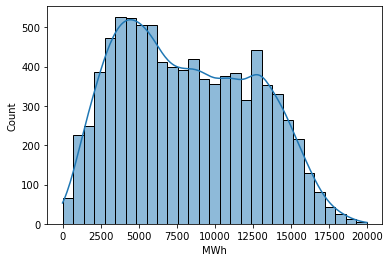

In [4]:
data = df['MWh']
sns.histplot(data=data, kde=True)

The data are measurements of a continuous quantity, so the following distributions will be ignored, since they are discrete:
- Bernoulli
- Binomial
- Uniform
- Poisson
- Zipfian

In [5]:
# Define a function to show the distribution and calculate the error
def plot_distribution(model, data):
    x = np.linspace(min(data), max(data), 100)
    y = model.pdf(x)
    
    f, ax = plt.subplots()
    n, bins, patches = ax.hist(data, bins=100, density=True)
    ax.plot(x, y)
    
    error = np.sum(np.power(y-n, 2))
    
    plt.xlabel('MWh')
    plt.ylabel('Count')
    plt.title(f'Error= {error:.2e}')
    plt.tight_layout()

In [6]:
# Define a common scale for all distributions based on data
scale=max(data)-min(data)

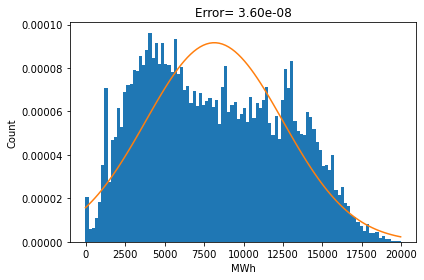

In [7]:
# Check Normal Distribution

from scipy.stats import norm

fit=norm.fit(data, scale=scale)
model=norm(loc=fit[0], scale=fit[1])
plot_distribution(model, data)

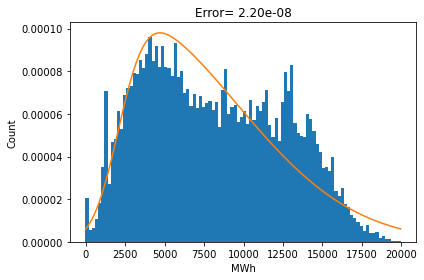

In [8]:
# Check Skew-Normal Distribution

from scipy.stats import skewnorm

fit=skewnorm.fit(data, scale=scale)
model=skewnorm(a=fit[0], loc=fit[1], scale=fit[2])
plot_distribution(model, data)

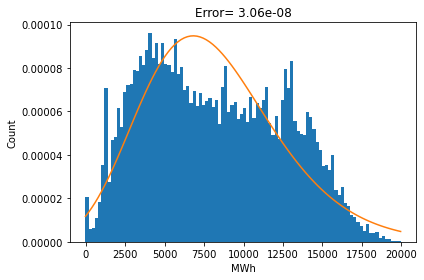

In [9]:
# Check Log-Normal Distribution

from scipy.stats import lognorm

fit=lognorm.fit(data, scale=scale)
model=lognorm(s=fit[0], loc=fit[1], scale=fit[2])
plot_distribution(model, data)

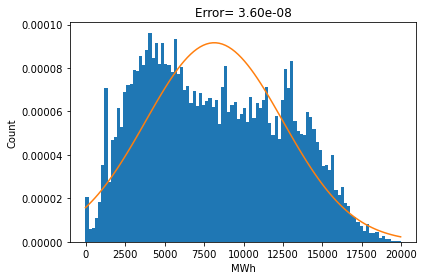

In [10]:
# Check Student's t Distribution

from scipy.stats import t

fit=t.fit(data, scale=scale)
model=t(df=fit[0], loc=fit[1], scale=fit[2])
plot_distribution(model, data)

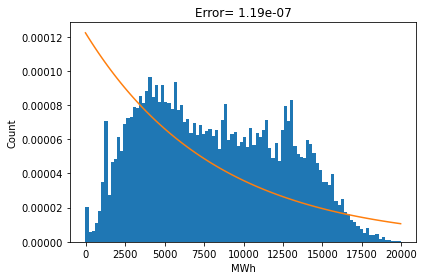

In [11]:
# Check Exponential Distribution

from scipy.stats import expon

fit=expon.fit(data, scale=scale)
model=expon(loc=fit[0], scale=fit[1])
plot_distribution(model, data)

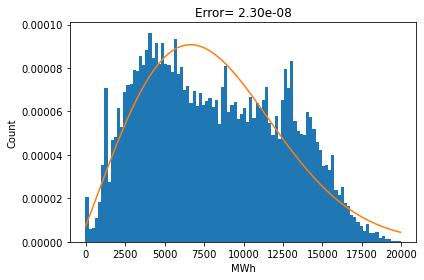

In [12]:
# Check Weibull Distribution

from scipy.stats import weibull_min

fit=weibull_min.fit(data, scale=scale)
model=weibull_min(c=fit[0], loc=fit[1], scale=fit[2])
plot_distribution(model, data)

According to the plots, the data is more similar to a Skew-Normal distribution.

In [13]:
fit=skewnorm.fit(data, scale=scale)

print(f'Model Parameters: \n Skewness=\t\t {fit[0]:.2}\n Mean=\t\t\t {fit[1]:.2}\n Standard Deviation=\t {fit[2]:.2}')

Model Parameters: 
 Skewness=		 5.6
 Mean=			 2.1e+03
 Standard Deviation=	 7.5e+03


According to the central limit theorem, the average of many samples from a population tend towards a normal distribution, regardless of the original data shape. <br>
We test it through Bootstrap Sampling

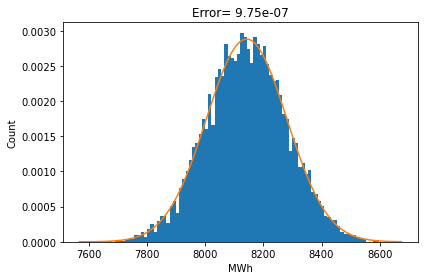

In [14]:
means = []
for i in range(10000):
    samples = np.random.choice(data, 1000, replace=True)
    means.append(samples.mean())

scale=max(data)-min(data)

fit=norm.fit(means, scale=scale)
model=norm(loc=fit[0], scale=fit[1])
plot_distribution(model, means)

There is a good match, so the theorem is approved.

In [15]:
# Since we look for differences between seasons, we use a post-hoc test.
from scikit_posthocs import posthoc_tukey

print(df.groupby('Season').mean())

posthoc_tukey(df, group_col='Season', val_col='MWh')

                MWh
Season             
1       8633.673109
2       8133.448080
3       6196.859293
4       9630.911795


,1,2,3,4
1,1.000,0.001,0.001,0.001
2,0.001,1.000,0.001,0.001
3,0.001,0.001,1.000,0.001
4,0.001,0.001,0.001,1.000


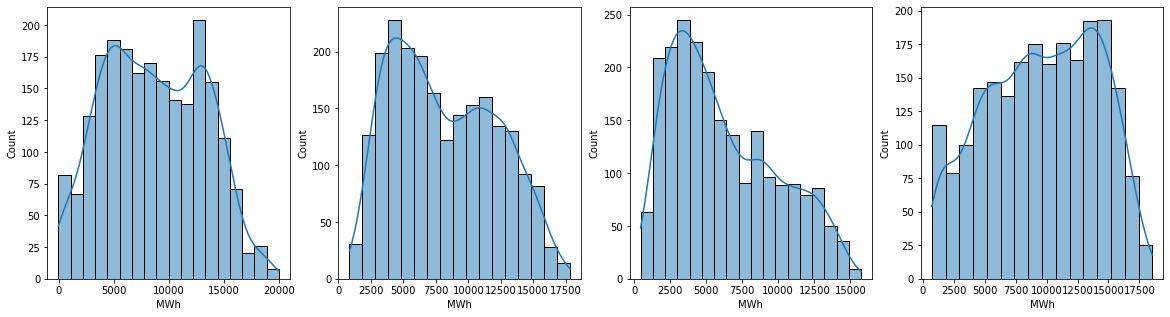

In [16]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(0, 4):
    data = df[df['Season'] == i + 1]['MWh']
    sns.histplot(ax=ax[i], data=data, kde=True)


Although the mean values for fall is the strongest and for summer is the weakest, there is a significant difference between the seasons.